# Programming assignment 4: SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

from cvxopt import matrix, solvers

## Your task

In this sheet we will implement a simple binary SVM classifier.
Your task is to complete the functions where required. 
You are only allowed to use built-in Python functions, as well as any `numpy` functions. No other libraries / imports are allowed.

To solve optimization tasks we will use **`CVXOPT`** http://cvxopt.org/ - a Python library for convex optimization. If you use `Anaconda`, you can install it using

    conda install cvxopt

## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On a Linux machine you can simply use `pdfunite`, there are similar tools for other platforms too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` Version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

## Generate and visualize the data

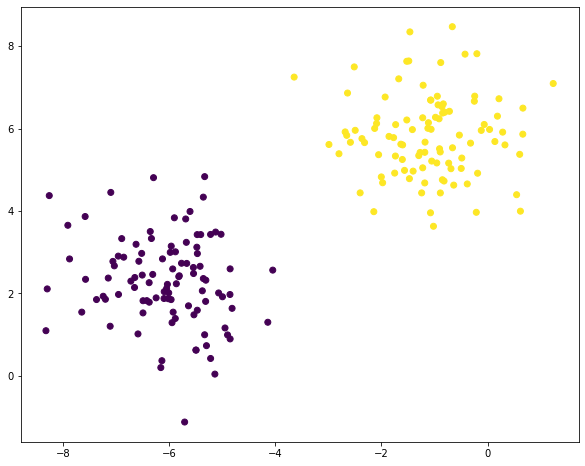

In [2]:
N = 200  # number of samples
D = 2  # number of dimensions
C = 2  # number of classes
seed = 1234  # for reproducible experiments

alpha_tol = 1e-4 # threshold for choosing support vectors

X, y = make_blobs(n_samples=N, n_features=D, centers=C, random_state=seed)
y[y == 0] = -1  # it is more convenient to have {-1, 1} as class labels (instead of {0, 1})
y = y.astype(np.float)
plt.figure(figsize=[10, 8])
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Task 1: Solving the SVM dual problem

Remember, that the SVM dual problem can be formulated as a Quadratic programming (QP) problem.
We will solve it using a QP solver from the `CVXOPT` library.

We use the following form of a QP problem:
$$
\text{minimize}_{\mathbf{x}}\quad
    \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x} \\
\text{subject to}\quad
    \mathbf{G}\mathbf{x} \le \mathbf{h}\text{ and }
    \mathbf{A}\mathbf{x} = \mathbf{b}\, .
$$

**Your task** is to formulate the SVM dual problems as a QP of this form and solve it using `CVXOPT`, i.e. specify the matrices $\mathbf{P}, \mathbf{G}, \mathbf{A}$ and vectors $\mathbf{q}, \mathbf{h}, \mathbf{b}$.

In [3]:
def solve_dual_svm(X, y):
    """Solve the dual formulation of the SVM problem.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    alphas : array, shape [N]
        Solution of the dual problem.
    """
    ### TODO: Your code below ###
    # These variables have to be of type cvxopt.matrix
    N, D = X.shape
    Q = -np.multiply(np.outer(y, np.transpose(y)), np.matmul(X, np.transpose(X)))
    
    P = matrix(-Q)
    q = matrix(-np.ones(N))
    G = matrix(-1.0 * np.identity(N))
    h = matrix(np.zeros(N))
    A = matrix(y, (1,N))
    b = matrix(0.)
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])
    return alphas.reshape(-1)

## Task 2: Recovering the weights and the bias

In [4]:
def compute_weights_and_bias(alpha, X, y):
    """Recover the weights w and the bias b using the dual solution alpha.
    
    Parameters
    ----------
    alpha : array, shape [N]
        Solution of the dual problem.
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    ### TODO: Your code below ###
    support_indices = np.argwhere(alpha > alpha_tol).flatten()
    
    N, D = X.shape
    #   w = np.sum(alpha[support_indices]*y[support_indices]*X[support_indices], axis=0)
    vals = alpha*y
    vals = np.repeat(vals[:, np.newaxis], D, axis=1)
    mult = np.multiply(vals[support_indices], X[support_indices])
    w = np.sum(mult, axis=0)
    ind = support_indices[0]
    b = y[ind] - np.transpose(w).dot(X[ind])
    return w, b

## Visualize the result (nothing to do here)

In [5]:
def plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b):
    """Plot the data as a scatter plot together with the separating hyperplane.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    alpha : array, shape [N]
        Solution of the dual problem.
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    plt.figure(figsize=[10, 8])
    # Plot the hyperplane
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.linspace(X[:, 0].min(), X[:, 0].max())
    plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
    plt.plot(x, x * slope + intercept - 1/w[1], 'k--')
    plt.plot(x, x * slope + intercept + 1/w[1], 'k--')
    # Plot all the datapoints
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # Mark the support vectors
    support_vecs = (alpha > alpha_tol)
    plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper left')

The reference solution is

    w = array([0.73935606 0.41780426])
    
    b = 0.919937145

Indices of the support vectors are
    
    [ 78 134 158]

In [6]:
alpha = solve_dual_svm(X, y)
w, b = compute_weights_and_bias(alpha, X, y)
print("w =", w)
print("b =", b)
print("support vectors:", np.arange(len(alpha))[alpha > alpha_tol])

w = [0.73940861 0.41770617]
b = 0.9206912669307183
support vectors: [ 78 134 158]


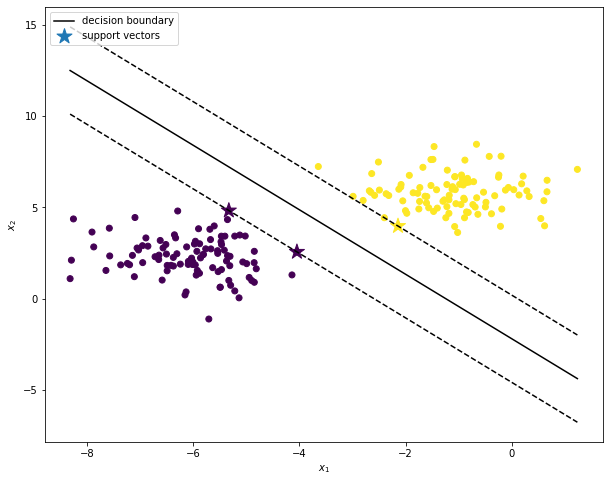

In [7]:
plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b)
plt.show()